<a href="https://colab.research.google.com/github/shuchimishra/Tensorflow_projects/blob/main/Tensorflow_Code/CNN/Flower_Preprocessing_using_tf_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [29]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt


# Download the flowers dataset

This tutorial uses a dataset of several thousand photos of flowers. The flowers dataset contains five sub-directories, one per class:

```
flowers_photos/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
archive = tf.keras.utils.get_file(origin=dataset_url, extract=True)
data_dir = pathlib.Path(archive).with_suffix('')

228813984/228813984 [==============================] - 5s 0us/step


After downloading (218MB), you should now have a copy of the flower photos available. There are 3,670 total images:

In [14]:
image_count = len(list(data_dir.glob('*/*.jpg'))) #The glob module finds all the pathnames matching a specified pattern according to the rules used by the Unix shell
print(image_count)

3670


In [24]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
img_height = 180
img_width = 180

# Using tf.data for finer control

The above Keras preprocessing utility—`tf.keras.utils.image_dataset_from_directory`—is a convenient way to create a `tf.data.Dataset` from a directory of images.

For finer grain control, you can write your own input pipeline using `tf.data`. This section shows how to do just that, beginning with the file paths from the TGZ file you downloaded earlier.

### Shuffle dataset

In [3]:
#The default behavior of this method is to return filenames in a non-deterministic random shuffled order. Pass a seed or shuffle=False to get results in a deterministic order.

list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=True) #unshuffled copy

In [4]:
list_ds = list_ds.shuffle(buffer_size = list_ds.cardinality(),  #To uniformly shuffle the entire dataset, use buffer_size=dataset.cardinality().
                          reshuffle_each_iteration=False) #reshuffle_each_iteration controls whether the shuffle order should be different for each epoch.

In [5]:
for f in list_ds.take(5):
  print(f.numpy())

b'/root/.keras/datasets/flower_photos/daisy/506348009_9ecff8b6ef.jpg'
b'/root/.keras/datasets/flower_photos/daisy/1140299375_3aa7024466.jpg'
b'/root/.keras/datasets/flower_photos/daisy/3900172983_9312fdf39c_n.jpg'
b'/root/.keras/datasets/flower_photos/dandelion/8980266062_8387f6cc89.jpg'
b'/root/.keras/datasets/flower_photos/sunflowers/4745985619_249078cafa_n.jpg'


### Derive classnames

The tree structure of the files can be used to compile a `class_names` list.

In [6]:
class_names = []

for directories in data_dir.glob('*'):
  print(directories)
  if directories.name != 'LICENSE.txt':
    class_names.append(directories.name)

class_names = np.array(sorted(class_names))
print(class_names)

/root/.keras/datasets/flower_photos/dandelion
/root/.keras/datasets/flower_photos/LICENSE.txt
/root/.keras/datasets/flower_photos/sunflowers
/root/.keras/datasets/flower_photos/daisy
/root/.keras/datasets/flower_photos/tulips
/root/.keras/datasets/flower_photos/roses
['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


OR, using list comprehension

In [7]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


### Split training and validation set

Split the dataset into training and validation sets:

In [15]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

### Dataset length

You can print the length of each dataset as follows:

In [16]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


Write a short function that converts a file path to an `(img, label)` pair:

In [ ]:
#Illustration of get_label function; uncomment to run
# for x in list_ds.take(5):
#   file_path = x.numpy()
#   print('\n',"Now processing file path :", file_path,'\n')

#   # 1. # Convert the path to a list of path components
#   parts = tf.strings.split(file_path, os.path.sep)
#   print("Splitted string :", parts.numpy(),'\n')
#   print("Label part of string :", parts[-2].numpy(),'\n')

#   # 2. # The second to last is the class-directory
#   one_hot = parts[-2] == class_names
#   print("One Hot encoded value :", one_hot.numpy(),'\n')
#   print("One Hot encoded value(after argmax method) :", tf.argmax(one_hot).numpy(),'\n')




 Now processing file path : b'/root/.keras/datasets/flower_photos/daisy/4613992315_143ccc2a10_m.jpg' 

Splitted string : [b'' b'root' b'.keras' b'datasets' b'flower_photos' b'daisy'
 b'4613992315_143ccc2a10_m.jpg'] 

Label part of string : b'daisy' 

One Hot encoded value : [ True False False False False] 

One Hot encoded value(after argmax method) : 0 


 Now processing file path : b'/root/.keras/datasets/flower_photos/dandelion/17075803866_aeeded2637.jpg' 

Splitted string : [b'' b'root' b'.keras' b'datasets' b'flower_photos' b'dandelion'
 b'17075803866_aeeded2637.jpg'] 

Label part of string : b'dandelion' 

One Hot encoded value : [False  True False False False] 

One Hot encoded value(after argmax method) : 1 


 Now processing file path : b'/root/.keras/datasets/flower_photos/sunflowers/13117907313_86c99c6441.jpg' 

Splitted string : [b'' b'root' b'.keras' b'datasets' b'flower_photos' b'sunflowers'
 b'13117907313_86c99c6441.jpg'] 

Label part of string : b'sunflowers' 

One Hot

### Convert file path to an (img, label) pair

#### Approach 1

In [17]:
n_classes = len(class_names)

def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    bool_values = tf.equal(parts[-2], class_names)
    indices = tf.where(bool_values)
    one_hot = tf.one_hot(indices, depth=n_classes)
    return one_hot

for x in list_ds.take(5):
  file_path = x.numpy()
  print('\n',"Now processing file path :", file_path,'\n')
  exp = get_label(file_path)
  print("Output is : ", get_label(file_path).numpy(),'\n')
  print("One hot encoding is :", exp[0,0,:].numpy(),'\n')
  print("Categorical output is :",np.argmax(exp[0,0,:]),'\n')


 Now processing file path : b'/root/.keras/datasets/flower_photos/sunflowers/9491955955_d0b2c83834.jpg' 

Output is :  [[[0. 0. 0. 1. 0.]]] 

One hot encoding is : [0. 0. 0. 1. 0.] 

Categorical output is : 3 


 Now processing file path : b'/root/.keras/datasets/flower_photos/daisy/102841525_bd6628ae3c.jpg' 

Output is :  [[[1. 0. 0. 0. 0.]]] 

One hot encoding is : [1. 0. 0. 0. 0.] 

Categorical output is : 0 


 Now processing file path : b'/root/.keras/datasets/flower_photos/tulips/130684941_d1abfa3be6_m.jpg' 

Output is :  [[[0. 0. 0. 0. 1.]]] 

One hot encoding is : [0. 0. 0. 0. 1.] 

Categorical output is : 4 


 Now processing file path : b'/root/.keras/datasets/flower_photos/daisy/2454280137_e1637536ae_n.jpg' 

Output is :  [[[1. 0. 0. 0. 0.]]] 

One hot encoding is : [1. 0. 0. 0. 0.] 

Categorical output is : 0 


 Now processing file path : b'/root/.keras/datasets/flower_photos/sunflowers/7721658400_0dec46d225.jpg' 

Output is :  [[[0. 0. 0. 1. 0.]]] 

One hot encoding is :

In [ ]:
# import tensorflow as tf

# x = tf.convert_to_tensor([True, False, False])

# tf.argmax(x)

<tf.Tensor: shape=(), dtype=int64, numpy=0>

#### Approach 2

In [18]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

for x in list_ds.take(5):
  file_path = x.numpy()
  print('\n',"Now processing file path :", file_path,'\n')
  one_hot = tf.one_hot(get_label(file_path).numpy(), depth=n_classes).numpy()
  print("Output is : ", get_label(file_path).numpy(),'\n')
  print("One hot encoding is :", one_hot,'\n')
  # print("Categorical output is :",np.argmax(exp[0,0,:]),'\n')


 Now processing file path : b'/root/.keras/datasets/flower_photos/daisy/4694730335_2553e77aa5_z.jpg' 

Output is :  0 

One hot encoding is : [1. 0. 0. 0. 0.] 


 Now processing file path : b'/root/.keras/datasets/flower_photos/tulips/7205698252_b972087cc2.jpg' 

Output is :  4 

One hot encoding is : [0. 0. 0. 0. 1.] 


 Now processing file path : b'/root/.keras/datasets/flower_photos/sunflowers/20344282483_05abb0b837.jpg' 

Output is :  3 

One hot encoding is : [0. 0. 0. 1. 0.] 


 Now processing file path : b'/root/.keras/datasets/flower_photos/sunflowers/18237215308_a158d49f28_n.jpg' 

Output is :  3 

One hot encoding is : [0. 0. 0. 1. 0.] 


 Now processing file path : b'/root/.keras/datasets/flower_photos/dandelion/23659122395_3467d88c02_n.jpg' 

Output is :  1 

One hot encoding is : [0. 1. 0. 0. 0.] 



In [ ]:
## Illustration of below function
# for x in train_ds.take(1):
#   print("Now processing path :", x.numpy(), '\n')
#   img = tf.io.read_file(x.numpy())
#   img = tf.io.decode_jpeg(contents = img, channels = 3)
#   print("Pixel version of image : ", img.numpy(), "and shape is :", img.shape, '\n')
#   img = tf.image.resize(img, [img_height, img_width])
#   print("Resized Pixel version of image : ", img.numpy(), "and shape is :", img.shape, '\n')

Now processing path : b'/root/.keras/datasets/flower_photos/daisy/4333085242_bbeb3e2841_m.jpg' 

Pixel version of image :  [[[213 213 213]
  [212 212 212]
  [210 210 210]
  ...
  [ 83 130 208]
  [ 85 131 209]
  [ 88 131 210]]

 [[215 215 215]
  [214 214 214]
  [212 212 212]
  ...
  [ 85 131 209]
  [ 87 133 211]
  [ 90 133 212]]

 [[218 217 215]
  [217 216 214]
  [216 214 215]
  ...
  [ 87 133 211]
  [ 91 134 212]
  [ 92 135 213]]

 ...

 [[121 135  58]
  [127 150  44]
  [151 153  78]
  ...
  [107 138  34]
  [107 132  31]
  [124 139  56]]

 [[126 147  56]
  [125 146  43]
  [ 95 107  25]
  ...
  [108 138  40]
  [111 134  30]
  [132 143  49]]

 [[120 146  36]
  [127 140  60]
  [115 134  44]
  ...
  [118 134  46]
  [129 135  35]
  [155 145  50]]] and shape is : (240, 240, 3) 

Resized Pixel version of image :  [[[213.16666  213.16666  213.16666 ]
  [211.33333  211.33333  211.33333 ]
  [209.5      209.5      211.16666 ]
  ...
  [ 83.19444  130.16667  208.16667 ]
  [ 84.333336 130.75     208

In [19]:
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [20]:
def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

Use `Dataset.map` to create a dataset of `image, label` pairs:

In [25]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [26]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  2


### Configure dataset for performance

To train a model with this dataset you will want the data:

* To be well shuffled.
* To be batched.
* Batches to be available as soon as possible.

These features can be added using the `tf.data` API. For more details, visit the [Input Pipeline Performance](../../guide/performance/datasets.ipynb) guide.

In [27]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

### Visualize the data

You can visualize this dataset similarly to the one you created previously:

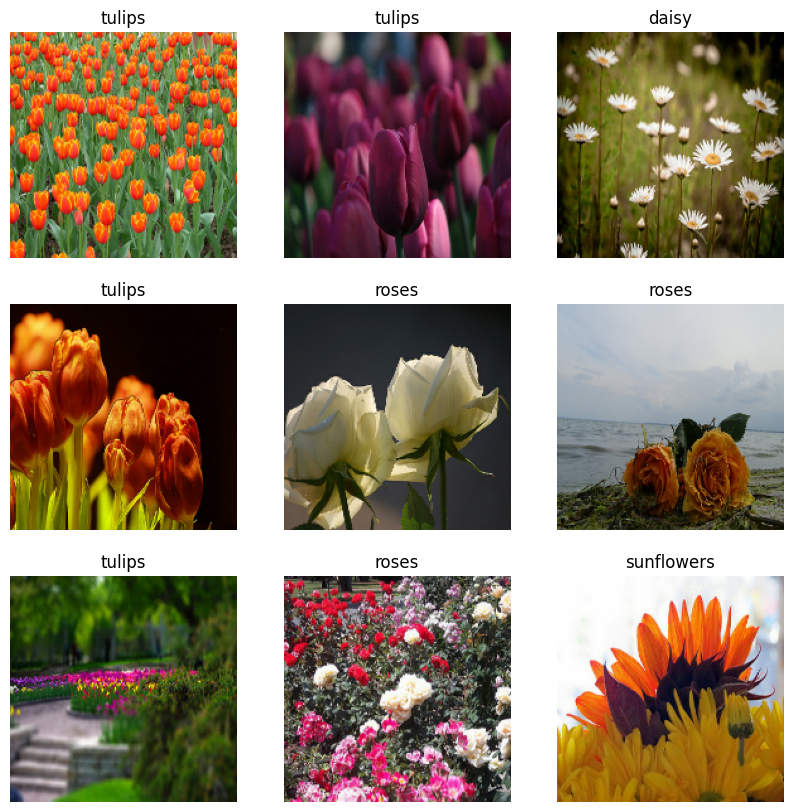

In [30]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

### Train a model

For completeness, you will show how to train a simple model using the datasets you have just prepared.

The [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). This model has not been tuned in any way—the goal is to show you the mechanics using the datasets you just created. To learn more about image classification, visit the [Image classification](../images/classification.ipynb) tutorial.

In [32]:
num_classes = 5

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

Choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [33]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #from_logits=True explanation - https://stackoverflow.com/questions/57253841/from-logits-true-and-from-logits-false-get-different-training-result-for-tf-loss/71365020#71365020
  metrics=['accuracy'])

### Continue training the model

You have now manually built a similar `tf.data.Dataset` to the one created by `tf.keras.utils.image_dataset_from_directory` above. You can continue training the model with it. As before, you will train for just a few epochs to keep the running time short.

In [34]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
13/92 [===>..........................] - ETA: 1:43 - loss: 1.5887 - accuracy: 0.2861

KeyboardInterrupt: 